# Recommendation System for Retail Customer—A Hands-On Example Using Tensorrec Python Module

by Taufik Azri

This example will use a dataset available here: 
https://www.kaggle.com/darpan25bajaj/retail-case-study-data#prod_cat_info.csv

Info and installation of Tensorrec module is here: https://github.com/jfkirk/tensorrec 

In [1]:
# Import the standard packages normally utilize by Data Scientist
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import Counter
import scipy.sparse as sparse

# os is a handy module to explore operating system directory
import os

# import keras as the Tensorflow engine uses Keras Neural Net backend
import keras as ks

# Import Tensorrec recommendation packages
import tensorrec
from tensorrec import TensorRec
from tensorrec.eval import *
from tensorrec.util import append_to_string_at_point

### the rest of these representation graphs are also available as an alternative
### feel free to play around to tune up the model
from tensorrec.representation_graphs import (AbstractKerasRepresentationGraph, 
#                                              ReLURepresentationGraph, 
                                             NormalizedLinearRepresentationGraph, 
#                                              LinearRepresentationGraph
                                            )

from tensorrec.loss_graphs import (WMRBLossGraph, 
#                                    BalancedWMRBLossGraph,
#                                    RMSELossGraph, 
#                                    RMSEDenseLossGraph, 
#                                    SeparationDenseLossGraph
                                  ) 

from tensorrec.eval import fit_and_eval, eval_random_ranks_on_dataset
from tensorrec.util import append_to_string_at_point

### we need to construct a Keras representation graph by inheriting tensorrec.representation_graphs.AbstractKerasRepresentationGraph
### https://www.tensorflow.org/tensorboard/graphs
### many thanks to James Kirk for his article: 
### https://medium.com/hackernoon/deep-learning-for-recommendation-with-keras-and-tensorrec-2b8935c795d0

class DeepRepresentationGraph(AbstractKerasRepresentationGraph):

    # This method returns an ordered list of Keras layers connecting the user/item features to the user/item
    # representation. When TensorRec learns, the learning will happen in these layers.
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'), #rectified linear unit
            ks.layers.Dense(n_components * 8, activation='relu'), #you can try other activation layer too
            ks.layers.Dense(n_components * 2, activation='relu'), #most likely changes only benefit other ML like image recog.
            ks.layers.Dense(n_components, activation='tanh'),
        ]

Using TensorFlow backend.


Import the data manually from Kaggle and save it somewhere in the directory

The dowloaded data contains three separate csv files: Customer, prod_cat_info, and Transaction. We will refer the Transaction.csv as the master data, which we will append the relevant customer and product information from Customer.csv before we insert them into the engine.

In [2]:
### use os.listdir to explore the files inside directory
os.listdir('../data_raw')

['Customer.csv', 'prod_cat_info.csv', 'Transactions.csv']

# Data Preparation

In [3]:
#### MASTER DATA, a.k.a Interaction

#### Import the master data, a.k.a transaction data
masterdf = pd.read_csv('../data_raw/Transactions.csv')
masterdf.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [4]:
### rename the columns for data cleanliness and standardization.
### Standardization will align the column name across tables for ease of merging

masterdf.columns = ['Transaction ID', 'Customer ID', 'Transaction Date', 'Prod Subcat Code',
       'Prod Cat Code', 'Qty', 'Rate', 'Tax', 'Total Amt', 'Store Type']

In [5]:
### Categorize store type into numeric category and save it into a new column

masterdf['Store Type Code'] = pd.factorize(masterdf['Store Type'])[0]
masterdf.head(5)

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Store Type Code
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,0
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,0
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,1
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,0
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,1


In [6]:
### ensure the categorization is unique
masterdf[['Store Type', 'Store Type Code']].drop_duplicates()

,Store Type,Store Type Code
0,e-Shop,0
2,TeleShop,1
8,MBR,2
17,Flagship store,3


In [7]:
#### CUSTOMER DATA a.k.a Customer Features

custdf = pd.read_csv('../data_raw/Customer.csv')
custdf.columns = ['Customer ID', 'DOB', 'Gender', 'City Code']
custdf.head(2)

,Customer ID,DOB,Gender,City Code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0


In [8]:
### how many null entries in the City Code?

len(custdf[custdf['City Code'].isnull()])

2

In [9]:
## where does our customers come from?

custdf['City Code'].unique()

array([ 4.,  8.,  2.,  1.,  5.,  9.,  7., 10.,  6.,  3., nan])

In [10]:
## how many customers exist in the transaction?

len(custdf['Customer ID'].unique())

5647

In [11]:
## what kinds of store type?

masterdf['Store Type'].unique()

array(['e-Shop', 'TeleShop', 'MBR', 'Flagship store'], dtype=object)

In [50]:
## load item feature

skudf = pd.read_csv('../data_raw/prod_cat_info.csv')
skudf.columns = ['Prod Cat Code', 'Prod Cat', 'Prod Sub Cat Code', 'Prod Subcat']
skudf.head()

,Prod Cat Code,Prod Cat,Prod Sub Cat Code,Prod Subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


Looks like there is not much info on the product, except the key-value for each category and subcategory.

# RFMV

In [9]:
## standardize transaction date into pandas datetime index
masterdf['Date'] =  pd.DatetimeIndex(masterdf['Transaction Date'], dayfirst=True).date

In [10]:
### what was the first transaction? the last one?

print(masterdf['Date'].min()), print(masterdf['Date'].max())

2011-01-25
2014-02-28


(None, None)

In [11]:
### calculate total net sales from quantity and based price (minus Tax, as it may be different from city to city)
masterdf['Net Sales'] = masterdf['Qty'] * masterdf['Rate']

In [12]:
### get unique material indicator from the category, subcategory, and the store type
### assuming different sku is sold to different store type

masterdf['Material'] = masterdf['Prod Cat Code'].astype(str) + '-' + masterdf['Prod Subcat Code'].astype(str) + '-' + masterdf['Store Type'].astype(str)

In [13]:
masterdf[['Prod Cat Code','Prod Subcat Code', 'Store Type', 'Material']].drop_duplicates(subset='Material').head(5)

,Prod Cat Code,Prod Subcat Code,Store Type,Material
0,1,1,e-Shop,1-1-e-Shop
1,3,5,e-Shop,3-5-e-Shop
2,5,6,TeleShop,5-6-TeleShop
3,6,11,e-Shop,6-11-e-Shop
5,3,8,TeleShop,3-8-TeleShop


In [14]:
### how many unique material we have in the dataset

len(masterdf['Material'].unique())

92

In [15]:
## get the date 'now', or for this case, the first day after the last transaction date
## the closer a transaction happen from this 'now' date, the better the recency of the data

import datetime as dt

now = dt.date(2014, 3, 1) # just take the max date from the index + 1
print(now)

2014-03-01


In [16]:
## RECENCY

recency_df = masterdf.groupby('Customer ID').Date.max().reset_index()
recency_df.columns = ['Customer ID','Last Purchase']
recency_df['Recency'] = recency_df['Last Purchase'].apply(lambda x: (now - x).days)
recency_df = recency_df[['Customer ID', 'Recency']]
recency_df.head()

,Customer ID,Recency
0,266783,374
1,266784,452
2,266785,212
3,266788,382
4,266794,17


In [17]:
# FREQUENCY

frequency_df = masterdf.groupby('Customer ID')['Date'].count().reset_index()
frequency_df.columns = ['Customer ID','Frequency']
frequency_df.head() 

,Customer ID,Frequency
0,266783,5
1,266784,3
2,266785,8
3,266788,4
4,266794,12


In [18]:
# MONETARY

monetary_df = masterdf.groupby('Customer ID')['Net Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID','Monetary']
monetary_df.head()

,Customer ID,Monetary
0,266783,13386
1,266784,5153
2,266785,31920
3,266788,5514
4,266794,25569


In [19]:
# # VARIETY

variety_df = masterdf.groupby('Customer ID')['Material'].nunique().reset_index()
variety_df.columns = ['Customer ID','Variety']
variety_df.head()

,Customer ID,Variety
0,266783,4
1,266784,3
2,266785,6
3,266788,4
4,266794,10


In [37]:
rfmv = recency_df.copy()

rfmv = rfmv.merge(frequency_df, on='Customer ID')
rfmv = rfmv.merge(monetary_df, on='Customer ID')
rfmv = rfmv.merge(variety_df, on='Customer ID')
rfmv.head(5)

,Customer ID,Recency,Frequency,Monetary,Variety
0,266783,374,5,13386,4
1,266784,452,3,5153,3
2,266785,212,8,31920,6
3,266788,382,4,5514,4
4,266794,17,12,25569,10


In [38]:
### we take the 25%, 50%, and 75% quantile for each of R, F, M, and V and store them into dictionary data type
rfmv_quantiles = rfmv.iloc[:, 1:].quantile(q = [0.25, 0.5, 0.75]).to_dict()
rfmv_quantiles

{'Frequency': {0.25: 3.0, 0.5: 4.0, 0.75: 6.0},
 'Monetary': {0.25: 5041.75, 0.5: 8801.0, 0.75: 13749.0},
 'Recency': {0.25: 92.0, 0.5: 212.0, 0.75: 405.0},
 'Variety': {0.25: 2.0, 0.5: 4.0, 0.75: 5.0}}

In [39]:
## create a function that returns a score--0 to 4 based on the quartile ranking
## these score can be easily interpreted by the K-Mean algorithm instead of the actual value of RFMB

### recency score: the lower the recency, the higher the score 
def RecencyScore(i, col, df):
    if i <= df[col][0.25]:
        return 4
    elif i <= df[col][0.50]:
        return 3
    elif i <= df[col][0.75]: 
        return 2
    else:
        return 1
    
# F, M, V: In contrast to Recency, the higher the quantile value, the higher the score    
def FMVScore(i, col, df):
    if i <= df[col][0.25]:
        return 1
    elif i <= df[col][0.50]:
        return 2
    elif i <= df[col][0.75]: 
        return 3    
    else:
        return 4

In [40]:
rfmv2 = rfmv.copy()

rfmv2['R_q'] = rfmv2['Recency'].apply(RecencyScore, args=('Recency', rfmv_quantiles ))
rfmv2['F_q'] = rfmv2['Frequency'].apply(FMVScore, args=('Frequency', rfmv_quantiles ))
rfmv2['M_q'] = rfmv2['Monetary'].apply(FMVScore, args=('Monetary', rfmv_quantiles ))
rfmv2['V_q'] = rfmv2['Variety'].apply(FMVScore, args=('Variety', rfmv_quantiles ))

rfmv2 = rfmv2[['Customer ID', 'R_q', 'F_q', 'M_q', 'V_q',]]

# # Sum total scores of each component

rfmv2['Total_Score'] = rfmv2['R_q'] + rfmv2['F_q'] + rfmv2['M_q'] + rfmv2['V_q']

rfmv2 = rfmv2[['Customer ID', 'Total_Score']]

# IMPORTANT: set index to customer number
rfmv2.index = rfmv2['Customer ID']
rfmv2 = rfmv2.drop('Customer ID', 1)

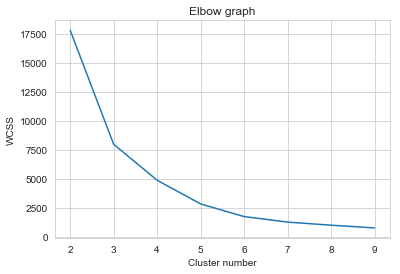

In [41]:
# We use elbow method to find the optimal number of clusters

wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++')
    kmeans.fit(rfmv2)
    wcss.append(kmeans.inertia_)
    
# Plot the graph for Elbow Method
plt.plot(range(2,10), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [42]:
# Apply KMean clustering using the optimal number with the "elbow" on the graph above
kmeans = KMeans(n_clusters=4, 
                init='random', 
                random_state=None)

clusters = kmeans.fit_predict(rfmv2)

### add the cluster result to the original rfmv dataframe
rfmv['Clusters'] = clusters

In [43]:
rfmv.head(5)

,Customer ID,Recency,Frequency,Monetary,Variety,Clusters
0,266783,374,5,13386,4,1
1,266784,452,3,5153,3,0
2,266785,212,8,31920,6,3
3,266788,382,4,5514,4,1
4,266794,17,12,25569,10,3


In [36]:
### counter is a nice function to see how many counts belong to each unique value
### in this case we want to know how may members allocated in each cluster

Counter(clusters)

Counter({0: 2003, 1: 1210, 2: 1436, 3: 857})

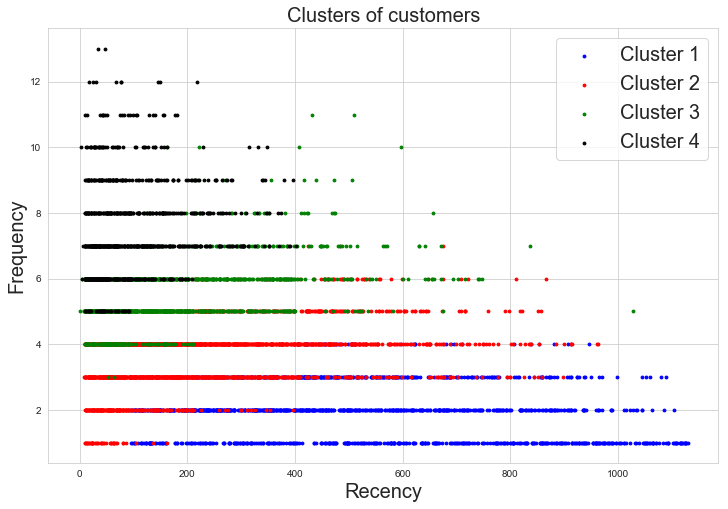

In [45]:
## optional: plot the two components with their respective RFMV to see the shape of the clusters
## optional: you can try to plot other RFMV components too

fig, ax = plt.subplots(figsize=(12,8))

var1 = 'Recency'
var2 = 'Frequency'
temp = rfmv.copy()

c1 = temp[temp.Clusters == 0]
c2 = temp[temp.Clusters == 1]
c3 = temp[temp.Clusters == 2]
c4 = temp[temp.Clusters == 3]

# Visualization of the clusters
plt.scatter(c1[var1], c1[var2], c = 'b', label = 'Cluster 1', s=8)
plt.scatter(c2[var1], c2[var2], c = 'r', label = 'Cluster 2', s=8)
plt.scatter(c3[var1], c3[var2], c = 'g', label = 'Cluster 3', s=8)
plt.scatter(c4[var1], c4[var2], c = 'k', label = 'Cluster 4', s=8)

plt.title('Clusters of customers', size=20)
plt.xlabel(var1, size=20)
plt.ylabel(var2, size=20)
plt.legend(fontsize=20)

# Recommendation Weight

In [46]:
### Depending on business use case, the rec engine may want to recommend to a certain type of customers, 
### i.e., recommend only to active customers, re-instate long-lost customers, recommend long-tailed/unpopular product etc.
### here, we will only recommend to active customers over the last year (within 365 days)

active_cust = rfmv[rfmv.Recency < 365]

In [51]:
### merge customer features--clusters and city--into master data

cleaned_df = masterdf.merge(active_cust[['Customer ID','Clusters']], how='left', on='Customer ID')

## removed any null entries on clusters (if any)
cleaned_df = cleaned_df[cleaned_df['Clusters'].notnull()]

## append customer table
cleaned_df = cleaned_df.merge(custdf[['Customer ID', 'City Code']], how='left', 
                on='Customer ID')

### merge sku feature--product category--into master data
cleaned_df = cleaned_df.merge(skudf[['Prod Cat', 'Prod Cat Code']], how='left', 
                on='Prod Cat Code')

In [52]:
### data sanity--check the length of transactions, customer, and sku

len(cleaned_df), len(cleaned_df['Customer ID'].unique()), len(cleaned_df['Material'].unique())

(77908, 3899, 92)

In [55]:
# Getting the required columns
# Get rid of unnecessary info, keep only essential columns
    
final_cleaned_df = cleaned_df

final_cleaned_df = final_cleaned_df[['Prod Cat','Material','Qty','Customer ID','Clusters',]]

# Group together to get total quantity for each customer, 
# retaining unique customer list, eliminating duplicates and redundancy
cust_grouped = final_cleaned_df.groupby(['Customer ID',
                                         'Prod Cat',
                                         'Material',
                                        'Clusters']).sum().reset_index()


In [56]:
### Interaction Matrix 
# Getting the Customer's transaction for every material interms of sales quantity
interactions = cust_grouped.groupby(['Customer ID', 'Material'])['Qty'].sum().unstack().fillna(0)

# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
minmaxscaler = preprocessing.MinMaxScaler()
interactions_scaled = minmaxscaler.fit_transform(interactions)
interactions_scaled = pd.DataFrame(interactions_scaled)

## The scaled matrix lost the index (customer) and column (item) information
## we re-append the customer ID and the material into the DataFrame's index and column respectively
interactions_scaled.index = interactions.index
interactions_scaled.columns = interactions.columns

In [57]:
interactions

Material,1-1-Flagship store,1-1-MBR,1-1-TeleShop,1-1-e-Shop,1-3-Flagship store,1-3-MBR,1-3-TeleShop,1-3-e-Shop,1-4-Flagship store,1-4-MBR,...,6-11-TeleShop,6-11-e-Shop,6-12-Flagship store,6-12-MBR,6-12-TeleShop,6-12-e-Shop,6-2-Flagship store,6-2-MBR,6-2-TeleShop,6-2-e-Shop
Customer ID,,,,,,,,,,,,,,,,,,,,,
266785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266794,0.0,0.0,0.0,0.0,0.0,9.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,12.0,0.0,0.0,0.0
266809,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
266814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20.0,0.0,12.0,0.0,0.0,0.0,0.0


In [58]:
### User Features Matrix 
## There are two features that is used to build the user matrix here
## First is the customer's unique categories they buy 
## Second is the clusters they belong to

# Getting the unique categories they buy
# grouped them by the quantity per category
cust_qty = cust_grouped.groupby(['Customer ID', 'Prod Cat'])['Qty'].sum().unstack().fillna(0)

# Scaled value of the categories
# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
minmaxscaler = preprocessing.MinMaxScaler()
cust_qty_scaled = minmaxscaler.fit_transform(cust_qty)
cust_qty_scaled = pd.DataFrame(cust_qty_scaled)
cust_qty_scaled.index = cust_qty.index
cust_qty_scaled.columns = cust_qty.columns

## Include the Cluster features of the customers
## this is the additional feature that we want to add into the user feature
## the cluster serves as customer's "characteristics"
### we use groupby/nunique aggregation to get a one-hot encoding of each customer's clusters

cust_clus = cust_grouped.groupby(['Customer ID', 'Clusters'])['Clusters'].nunique().unstack().fillna(0)
cust_clus

# Merge the two features to create the user feature matrix
customer_features = pd.merge(cust_qty_scaled, cust_clus, left_index=True, right_index=True, how='inner')
customer_features = customer_features.rename(columns={0: 'Cluster 0', 
                                                      1: 'Cluster 1', 
                                                      2: 'Cluster 2', 
                                                      3: 'Cluster 3', 
                                                      4: 'Cluster 4'})

## as an additional practice, you can also include other user information from custdf, such as gender and date of birth
## but for now, I will omit those information

In [59]:
### Item Features Matrix
## We use the different categories of the items as the feature to build the item feature matrix here

item_category = pd.DataFrame(cust_grouped.groupby(['Material', 
                                              'Prod Cat'])['Qty'].sum().unstack().fillna(0).reset_index().set_index('Material'))
# item_cat = item_cat.applymap(replaceneg0)

# Scaled value of the item categories
minmaxscaler = preprocessing.MinMaxScaler()
item_category_scaled = minmaxscaler.fit_transform(item_category)
item_category_scaled = pd.DataFrame(item_category_scaled)
item_category_scaled.index = item_category.index
item_category_scaled.columns = item_category.columns

In [60]:
### We have three features as required by TensorRec
### TensorRec accept matrix, and not dataframe, therefore we need to transform them into matrix

## Create COOMatrices using Scipy function 
## COOMatrices are sparse matrices, mostly filled with zero
## It speeds up the processes and saves a lot of memory
interaction_f = sparse.coo_matrix(interactions_scaled)
user_f  = sparse.coo_matrix(customer_features) 
item_f  = sparse.coo_matrix(item_category_scaled) 

In [61]:
### Jesse Steinweg-Woods provide a great elaboration on Recommendation metrics
### The following code is borrowed from his work
### https://jessesw.com/Rec-System/

def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [62]:
mask_size = len(interaction_f.data)

### use numpy.random.choice to generate a random True/False array, where False denotes the "masked" interactions (hidden)
## https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8])

array([False,  True,  True, ..., False,  True,  True])

In [63]:
# Create a masked train and test dataset of the interaction features
train_interactions, test_interactions = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
item_features = item_f

In [64]:
## validate that the interactions are scipy coordinate sparse matrix

train_interactions

<3899x92 sparse matrix of type '<class 'numpy.float64'>'
	with 160772 stored elements in COOrdinate format>

In [65]:
%%time
### call %%time to see the time it takes to run the model 

## model parameters

epochs = 100 #number of iterations ## play around with this number to achieve an optimal learning curve
alpha = 0.01 
n_components =  10 ## play around with this number to achieve an optimal learning curve

verbose = True
learning_rate = 0.01
n_sampled_items = int(item_features.shape[0] * .1)
biased = False
 
k_val  = 100

## Approximation of WMRB: Learning to Rank in a Scalable Batch Training Approach .
### Interactions can be any positive values, but magnitude is ignored. Negative interactions are ignored
### http://ceur-ws.org/Vol-1905/recsys2017_poster3.pdf
#  Options: BalancedWMRBLossGraph,RMSELossGraph, RMSEDenseLossGraph, SeparationDenseLossGraph

model = TensorRec(n_components = n_components,                 
                  user_repr_graph = DeepRepresentationGraph(),
                   item_repr_graph = NormalizedLinearRepresentationGraph(),
                   loss_graph = WMRBLossGraph(), 
                  biased=biased)

model.fit(train_interactions, 
          user_features, 
          item_features, 
          epochs=epochs, 
          verbose=False, 
          alpha=alpha, 
          n_sampled_items=n_sampled_items,
          learning_rate=learning_rate)


# # Get predicted scores for all users and all items
# predictions = model.predict(user_features=user_features,
#                             item_features=item_features)

# Get the predicted rankings (First, second, third, and so forth...) for all users and all items
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D

Wall time: 16.6 s


In [66]:
%%time

### TESTING

# we use Recall@k
# Recall@k: for the average user, what percentage of their test items made it in to the top k in the predicted rankings

# in other words, recall@k:
# what percentage of the positively interacted items (items purchased) were in the top k results of the prediction?

# in simpler words:
# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
#a.k.a
# Recall@k = (# of recommended items @k ) / (total # items purchased)

### reference: 

## optimally, if you have around 400-500 products, you want to achieve recall at k ≈ 200-250
## but since we only have 92 products, k=80 may sounds fitting.
r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=80)
r_at_k_train = recall_at_k(predicted_ranks, train_interactions, k=80)
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(r_at_k_train.mean(), r_at_k_test.mean()))

Recall at @k: Train: 0.90 Test: 0.90
Wall time: 30.3 ms


In [67]:
# produce the ranking into a readable table (dataframe it is)
ranks_df = pd.DataFrame(predicted_ranks)
ranks_df.columns = item_category_scaled.index
ranks_df.index = customer_features.index
ranks_df = ranks_df.T

In [68]:
ranks_df.head(5)

Customer ID,266785,266794,266799,266804,266805,266806,266809,266813,266814,266815,...,275245,275246,275247,275249,275250,275252,275255,275257,275261,275265
Material,,,,,,,,,,,,,,,,,,,,,
1-1-Flagship store,1,3,3,1,3,2,5,4,2,1,...,1,2,3,1,4,1,1,1,3,1
1-1-MBR,7,4,7,2,4,3,8,5,6,7,...,2,7,4,7,7,2,7,7,4,2
1-1-TeleShop,8,5,8,9,9,4,9,6,7,10,...,10,8,5,8,10,3,9,8,5,11
1-1-e-Shop,2,6,4,3,5,5,6,7,3,2,...,3,3,6,2,5,4,2,2,6,3
1-3-Flagship store,6,7,5,4,6,6,10,8,8,3,...,4,4,7,3,6,5,3,3,7,4
